In [1]:
using CairoMakie
using LinearAlgebra
using Base.Threads
using ChunkSplitters
using Statistics

const H = 6000f0
const W = 8000f0
const R = 50f0
const G = -1000f0
""

""

In [2]:
mutable struct PhysicsObject
    position::Vector{Float32}
    velocity::Vector{Float32}
    acceleration::Vector{Float32}
end

PhysicsObject(x,y) = PhysicsObject([x,y], [0f0,0f0], [0f0,G])
PhysicsObject(px, py, vx, vy) = PhysicsObject([px,py], [vx,vy], [0f0,G])

function updateVelocity(physObj::PhysicsObject, dt::Float32)
    physObj.velocity += physObj.acceleration * dt
end

function updatePosition(physObj::PhysicsObject, dt::Float32)
    newPos = physObj.position + physObj.velocity * dt
    if (newPos[1] < R && physObj.velocity[1] < 0) || (newPos[1] > W - R && physObj.velocity[1] > 0) 
        physObj.velocity[1] = -physObj.velocity[1]
    end
    if (newPos[2] < R && physObj.velocity[2] < 0) || (newPos[2] > H - R && physObj.velocity[2] > 0)
        physObj.velocity[2] = -physObj.velocity[2]
    end
    physObj.position = [clamp(newPos[1], R, W-R), clamp(newPos[2], R, H-R)]
end

updatePosition (generic function with 1 method)

In [3]:
function physicsStep(objects::Vector{PhysicsObject}, dt::Float32)
    for obj in objects
        updateVelocity(obj, dt)
        updatePosition(obj, dt)
    end
end

physicsStep (generic function with 1 method)

In [4]:
function threadStep(objects::Vector{PhysicsObject}, dt::Float32)
    @sync for (range, chunk) in chunks(1:length(objects), nthreads(), :scatter)
        @spawn for i in range
            updateVelocity(objects[i], dt)
            updatePosition(objects[i], dt)
        end
    end
end

threadStep (generic function with 1 method)

In [5]:
function solveCollision(obj1::PhysicsObject, obj2::PhysicsObject)
    vec = obj1.position - obj2.position
    dist = sqrt(vec[1]^2 + vec[2]^2)
    if dist < 2R
        normal = vec / dist
        obj1.position += (2R-dist)/2 * normal
        obj2.position += (2R-dist)/2 * -normal
        obj1.velocity = obj1.velocity - 2(dot(obj1.velocity, normal)) * normal
        obj2.velocity = obj2.velocity - 2(dot(obj2.velocity, -normal)) * -normal
    end
end

solveCollision (generic function with 1 method)

In [6]:
function naiveCollision(objects::Vector{PhysicsObject})
    for obj1 in objects
        for obj2 in objects
            if obj1 != obj2 
                solveCollision(obj1, obj2)
            end
        end
    end
end

naiveCollision (generic function with 1 method)

In [7]:
function gridCollision(objects::Vector{PhysicsObject})
    
    grid = Array{Union{Vector{Int},Nothing}}(nothing, (floor(Int, W / 2R)+1), floor(Int, H / 2R)+1)
    
    #Set cells in grid with index of obects in cell.
    for (i, obj) in enumerate(objects)
        cellx = clamp(floor(Int, obj.position[1] / 2R) + 1, 1, floor(Int, W / 2R) + 1)
        celly = clamp(floor(Int, obj.position[2] / 2R) + 1, 1, floor(Int, H / 2R) + 1)
        if grid[cellx, celly] === nothing
            grid[cellx, celly] = Vector{Int}[]
        end
        push!(grid[cellx, celly], i)
    end

    #Traverse the Grid
    for x = 2:floor(Int, W / 2R)
        for y = 2:floor(Int, H / 2R)

            if grid[x, y] !== nothing # there are objects in the grid cell
                for o1 in grid[x, y] # Iterate through items in cell
                    
                    #Visit neighbor cells
                    for dx = -1:1
                        for dy = -1:1
                           
                            if @inbounds grid[x+dx, y+dy] !== nothing # Objects exist in neighbor cell
                                for o2 in @inbounds grid[x+dx, y+dy] # Iterate through items in cell
                                    if (o1 != o2) solveCollision(objects[o1], objects[o2]) end
                                end
                            end
                        end
                    end
                end
            end
        end
    end
end

gridCollision (generic function with 1 method)

In [8]:
function threadCollision(objects::Vector{PhysicsObject})

    grid = Array{Union{Vector{Int},Nothing}}(nothing, (floor(Int, W / 2R)) + 1, floor(Int, H / 2R) + 1)
    for (i, obj) in enumerate(objects)
        cellx = clamp(floor(Int, obj.position[1] / 2R) + 1, 1, floor(Int, W / 2R) + 1)
        celly = clamp(floor(Int, obj.position[2] / 2R) + 1, 1, floor(Int, H / 2R) + 1)
        if grid[cellx, celly] === nothing
            grid[cellx, celly] = Vector{Int}[]
        end
        push!(grid[cellx, celly], i)
    end

    # Split the grid in the x dim amonst the treads
    # using batch is important as we dont want 2 treads working on the same cell
    x_range = 1:floor(Int, W / 2R)-1
    @threads for (range, chunk) in chunks(x_range, nthreads(), :batch)
        @sync for x in range
            x += 1
            for y = 2:floor(Int, H / 2R)
                if grid[x, y] !== nothing
                    for o1 in grid[x, y] # Iterate through items in cell
                        #Visit neighbor cells
                        for dx = -1:1
                            for dy = -1:1
                                if grid[x+dx, y+dy] !== nothing
                                    for o2 in grid[x+dx, y+dy] # neighbor Items
                                        if (o1 != o2)
                                            solveCollision(objects[o1], objects[o2])
                                        end
                                    end
                                end
                            end
                        end
                    end
                end
            end
        end
    end
end

threadCollision (generic function with 1 method)

In [9]:
function setup()
    fig = Figure(backgroundcolor = :gray)
    points = Observable([Point2f(0,0)])
    colors = Observable([1])
    
    ax = Axis(fig[1,1])
    hidedecorations!(ax)
    xlims!(ax, (0, W))
    ylims!(ax, (0, H))
    mark = Sphere(Point3f(0,0,0), R)
    meshscatter!(ax, points; marker=mark, markersize=1, colormap=:rainbow, color=colors, colorrange=(1,100), aspect=:data)
    return fig, points, colors
end


setup (generic function with 1 method)

In [10]:
testObjects = Vector{PhysicsObject}()
for i=1:100
    newObj = PhysicsObject(W*rand(),H*rand())
    newObj.velocity = [randn()*200, randn()*200] 
    push!(testObjects, newObj)
end


In [11]:
function naiveAnimation(objects::Vector{PhysicsObject}, dt::Float32, points, colors)
    physicsStep(objects, dt)
    naiveCollision(objects)
    points[] = map(obj -> Point2f(obj.position), objects)
    #colors[] = map(n -> n%100 +1, [c for c in 1:length(objects)])
end    

naiveAnimation (generic function with 1 method)

In [12]:
naiveObjects = deepcopy(testObjects)

fig, points, colors = setup()
colors[] = map(n -> n%100 +1, [c for c in 1:length(naiveObjects)])


framerate = 60
time = 10
timestamps = range(0,time, step=1/framerate)
record(fig, "naivetest.mp4", timestamps; framerate=framerate) do i
    naiveAnimation(naiveObjects, Float32(1/framerate), points, colors)
end

"naivetest.mp4"

In [13]:
function gridAnimation(objects::Vector{PhysicsObject}, dt::Float32, points, colors)
    physicsStep(objects, dt)
    gridCollision(objects)
    points[] = map(obj -> Point2f(obj.position), objects)
    # colors[] = map(n -> n%100 +1, [c for c in 1:length(objects)])
end    

gridAnimation (generic function with 1 method)

In [14]:
gridObjects = deepcopy(testObjects)

fig, points, colors = setup()
colors[] = map(n -> n%100 +1, [c for c in 1:length(gridObjects)])

framerate = 60
time = 10
timestamps = range(0,time, step=1/framerate)
record(fig, "gridtest.mp4", timestamps; framerate=framerate) do i
    gridAnimation(gridObjects, Float32(1/framerate), points, colors)
end

"gridtest.mp4"

In [15]:
function threadAnimation(objects::Vector{PhysicsObject}, dt::Float32, points, colors)
    threadStep(objects, dt)
    threadCollision(objects)
    points[] = map(obj -> Point2f(obj.position), objects)
    #colors[] = map(n -> n%100 +1, [c for c in 1:length(objects)])
end    

threadAnimation (generic function with 1 method)

In [16]:
threadObjects = deepcopy(testObjects)

fig, points, colors = setup()
colors[] = map(n -> n%100 +1, [c for c in 1:length(threadObjects)])

framerate = 60
time = 10
timestamps = range(0,time, step=1/framerate)
record(fig, "threadtest.mp4", timestamps; framerate=framerate) do i
    threadAnimation(threadObjects, Float32(1/framerate), points, colors)
end

"threadtest.mp4"

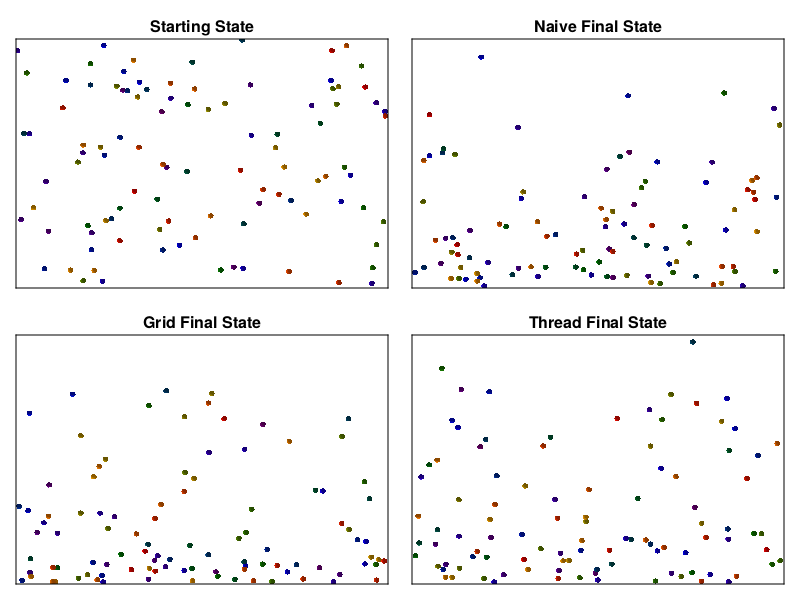

In [17]:
fig = Figure()
startax = Axis(fig[1, 1]; title="Starting State" )
naiveax = Axis(fig[1, 2]; title="Naive Final State")
gridax = Axis(fig[2, 1]; title="Grid Final State")
threadax = Axis(fig[2, 2]; title="Thread Final State")

hidedecorations!(startax)
hidedecorations!(naiveax)
hidedecorations!(gridax)
hidedecorations!(threadax)

xlims!(startax, (0, W))
ylims!(startax, (0, H))
xlims!(naiveax, (0, W))
ylims!(naiveax, (0, H))
xlims!(gridax, (0, W))
ylims!(gridax, (0, H))
xlims!(threadax, (0, W))
ylims!(threadax, (0, H))

startpoints = map(obj -> Point2f(obj.position), testObjects)
naivepoints = map(obj -> Point2f(obj.position), naiveObjects)
gridpoints = map(obj -> Point2f(obj.position), gridObjects)
threadpoints = map(obj -> Point2f(obj.position), threadObjects)

colors = map(n -> n%100 +1, [c for c in 1:length(testObjects)])

mark = Sphere(Point3f(0,0,0), R)

meshscatter!(startax, startpoints; marker=mark, markersize=1, colormap=:rainbow, color=colors, colorrange=(1,100), aspect=:data)
meshscatter!(naiveax, naivepoints; marker=mark, markersize=1, colormap=:rainbow, color=colors, colorrange=(1,100), aspect=:data)
meshscatter!(gridax, gridpoints; marker=mark, markersize=1, colormap=:rainbow, color=colors, colorrange=(1,100), aspect=:data)
meshscatter!(threadax, threadpoints; marker=mark, markersize=1, colormap=:rainbow, color=colors, colorrange=(1,100), aspect=:data)

fig

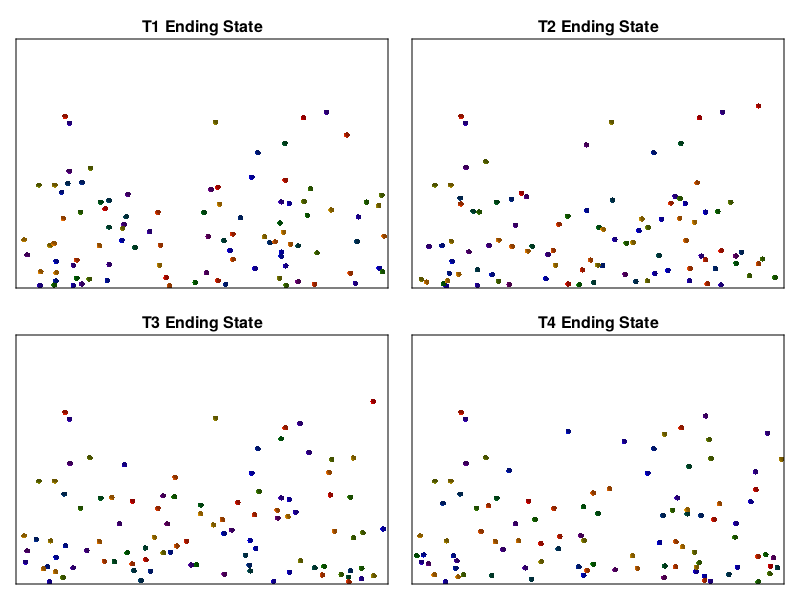

In [29]:
o1 = deepcopy(testObjects)
o2 = deepcopy(testObjects)
o3 = deepcopy(testObjects)
o4 = deepcopy(testObjects)

for i = 1:500
    threadStep(o1, 0.01f0); threadCollision(o1)
    threadStep(o2, 0.01f0); threadCollision(o2)
    threadStep(o3, 0.01f0); threadCollision(o3)
    threadStep(o4, 0.01f0); threadCollision(o4)
end

fig = Figure()
t1 = Axis(fig[1, 1]; title="T1 Ending State")
t2 = Axis(fig[1, 2]; title="T2 Ending State")
t3 = Axis(fig[2, 1]; title="T3 Ending State")
t4 = Axis(fig[2, 2]; title="T4 Ending State")

hidedecorations!(t1)
hidedecorations!(t2)
hidedecorations!(t3)
hidedecorations!(t4)

xlims!(t1, (0, W))
ylims!(t1, (0, H))
xlims!(t2, (0, W))
ylims!(t2, (0, H))
xlims!(t3, (0, W))
ylims!(t3, (0, H))
xlims!(t4, (0, W))
ylims!(t4, (0, H))

p1 = map(obj -> Point2f(obj.position), o1)
p2 = map(obj -> Point2f(obj.position), o2)
p3 = map(obj -> Point2f(obj.position), o3)
p4 = map(obj -> Point2f(obj.position), o4)

colors = map(n -> n%100 +1, [c for c in 1:length(o1)])

mark = Sphere(Point3f(0,0,0), R)

meshscatter!(t1, p1; marker=mark, markersize=1, colormap=:rainbow, color=colors, colorrange=(1,100), aspect=:data)
meshscatter!(t2, p2; marker=mark, markersize=1, colormap=:rainbow, color=colors, colorrange=(1,100), aspect=:data)
meshscatter!(t3, p3; marker=mark, markersize=1, colormap=:rainbow, color=colors, colorrange=(1,100), aspect=:data)
meshscatter!(t4, p4; marker=mark, markersize=1, colormap=:rainbow, color=colors, colorrange=(1,100), aspect=:data)
fig

In [18]:
benchObjects = Vector{PhysicsObject}()
for i=1:100
    newObj = PhysicsObject(W*rand(),H*rand())
    newObj.velocity = [randn()*200, randn()*200] 
    push!(benchObjects, newObj)
end

naiveObjects = deepcopy(benchObjects)
gridObjects = deepcopy(benchObjects)
threadObjects = deepcopy(benchObjects)
naiveTimes::Vector{Float32} = []
gridTimes::Vector{Float32} = []
threadTimes::Vector{Float32} = []

steps = 1:500

for i=steps
    push!(naiveTimes, convert(Float32, @elapsed begin physicsStep(naiveObjects, 0.01f0); naiveCollision(naiveObjects) end))
    push!(gridTimes, convert(Float32, @elapsed begin physicsStep(naiveObjects, 0.01f0); gridCollision(gridObjects) end))
    push!(threadTimes, convert(Float32, @elapsed begin threadStep(naiveObjects, 0.01f0); threadCollision(threadObjects) end))
end


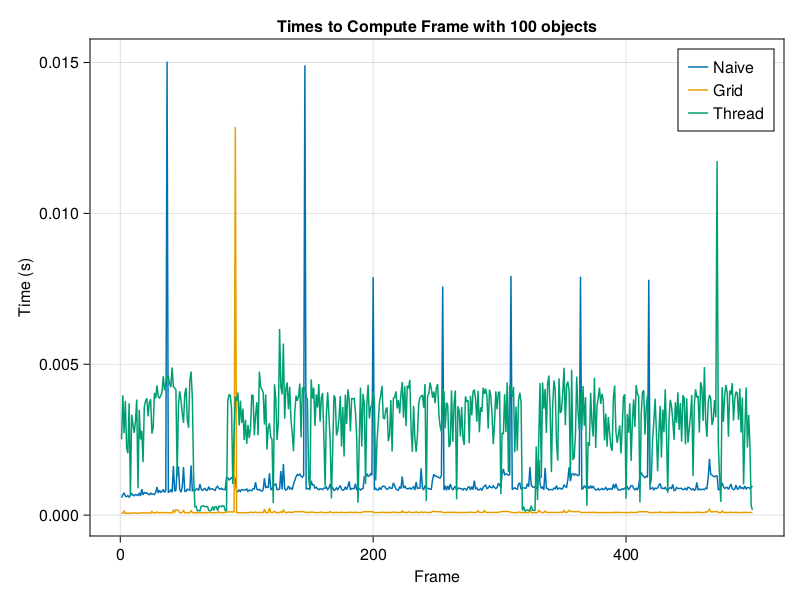

In [19]:

fig = Figure()
ax = Axis(fig[1, 1]; title="Times to Compute Frame with 100 objects", xlabel="Frame", ylabel="Time (s)")


lines!(collect(Float32, steps), naiveTimes; label="Naive")
lines!(collect(Float32, steps), gridTimes; label="Grid")
lines!(collect(Float32, steps), threadTimes; label="Thread")

axislegend(ax)

fig

In [20]:
println("Naive Avg: ", mean(naiveTimes))
println("Grid Avg: ", mean(gridTimes))
println("Thread Avg: ", mean(threadTimes))

Naive Avg: 0.0010743925
Grid Avg: 0.0001186352
Thread Avg: 0.0030939435


In [21]:
naiveObjects = Vector{PhysicsObject}()
gridObjects = Vector{PhysicsObject}()
threadObjects = Vector{PhysicsObject}()

naiveTimes::Vector{Float32} = []
gridTimes::Vector{Float32} = []
threadTimes::Vector{Float32} = []


maxObjects = 1000
steps = 1:maxObjects

for i=steps
    push!(naiveObjects, PhysicsObject(i*W/maxObjects,i*H/maxObjects))
    push!(gridObjects, PhysicsObject(i*W/maxObjects,i*H/maxObjects))
    push!(threadObjects, PhysicsObject(i*W/maxObjects,i*H/maxObjects))
    
    push!(naiveTimes, convert(Float32, @elapsed begin physicsStep(naiveObjects, 0.01f0); naiveCollision(naiveObjects) end))
    push!(gridTimes, convert(Float32, @elapsed begin physicsStep(gridObjects, 0.01f0); gridCollision(gridObjects) end))
    push!(threadTimes, convert(Float32, @elapsed begin threadStep(threadObjects, 0.01f0); threadCollision(threadObjects) end))
end


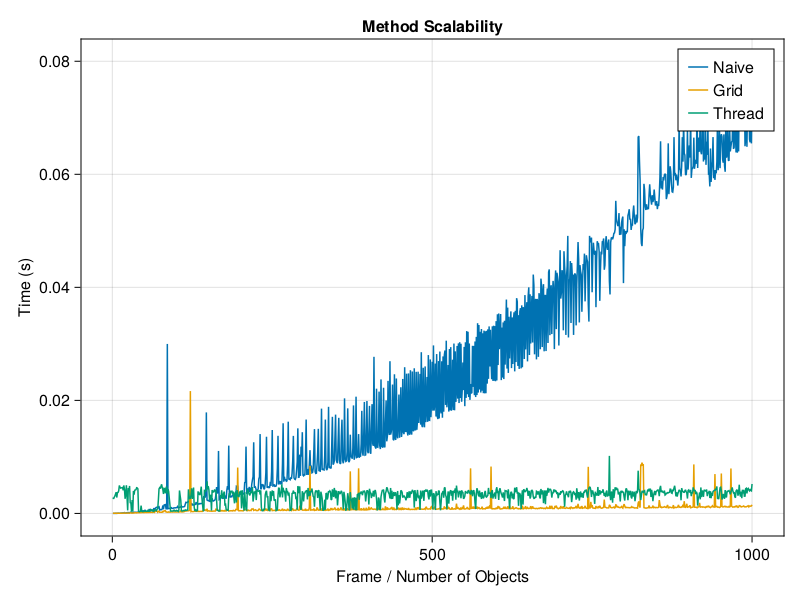

In [22]:

fig = Figure()
ax = Axis(fig[1, 1]; title="Method Scalability", xlabel="Frame / Number of Objects", ylabel="Time (s)")


lines!(collect(Float32, steps), naiveTimes; label="Naive")
lines!(collect(Float32, steps), gridTimes; label="Grid")
lines!(collect(Float32, steps), threadTimes; label="Thread")

axislegend(ax)

fig

In [23]:
println("Naive Avg: ", mean(naiveTimes))
println("Grid Avg: ", mean(gridTimes))
println("Thread Avg: ", mean(threadTimes))

Naive Avg: 0.026449418
Grid Avg: 0.00093711383
Thread Avg: 0.0031696723
